In [11]:
import tensorflow as tf
import numpy as np

In [12]:
#method for creating labels and features
def windowed_datset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer).batch(batch_size=batch_size).prefetch(1)
    return dataset

#Method for creating trend
def trend(time, slope=0):
    return slope * time

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

In [13]:
#Create a time series
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline =10
amplitude = 40
slope = 0.05
noise_level = 5
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [14]:
#Create training and validation datasets
split_time =1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [15]:
#Create features and labels
window_size= 20
batch_size= 32
shuffle_buffer=10

dataset = windowed_datset(series,window_size, batch_size, shuffle_buffer)
layers = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential(layers=layers)
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=1)


Epoch 1/100
46/46 [==============================] - 0s 5ms/step - loss: 699.2019
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 198.9373
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 114.9837

In [16]:
#print the weights. It will print first array of 20 items and second as one item. Whcih is same as liner regressuin
#Y = w0.x0 + w1.x1 + .... wn.xn + b(this is the last array with one value or also called bias or slope)
print("Layers {} ", model.get_weights())

Layers {}  [array([[-0.0357631 ],
       [-0.00387829],
       [ 0.05426926],
       [-0.01445746],
       [ 0.00638164],
       [-0.02541556],
       [-0.01460447],
       [ 0.0492866 ],
       [ 0.00730413],
       [-0.047043  ],
       [ 0.03263397],
       [ 0.00908722],
       [-0.00347794],
       [ 0.0365086 ],
       [ 0.03654652],
       [-0.01677021],
       [ 0.08294695],
       [ 0.18520406],
       [ 0.2851395 ],
       [ 0.41212162]], dtype=float32), array([0.01177839], dtype=float32)]


In [17]:
#Predict for next 20 values
print("Actual values: ")
print(series[1:25])

print("Predicted values")
'''
Note that we are pass series [1:21] because we have defined that our window size during prediction
is 20. If you change the value where range is more or less than (1:21) size=20, it will throw error
"np.newaxis" is used to reshape it to the input dimension used by the model.
'''
model.predict(series[1:21][np.newaxis])

Actual values: 
[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938 47.335835
 48.6033   40.93184  45.11266 ]
Predicted values


array([[50.76233]], dtype=float32)

In [25]:
#Create a forecasted series for plotting the predited values.
forecast =[]
for value in range(len(series) - window_size):
    forecast.append(model.predict(series[value: value + window_size][np.newaxis]))
# We got the full prediction 0 to n but we only want to see the values in the validation part.
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]



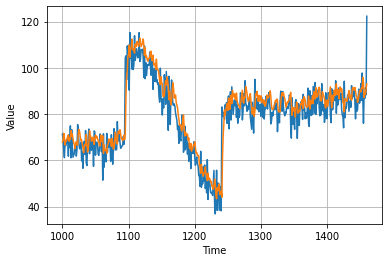

In [26]:
#methow for plotting
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plot_series(time_valid,x_valid)
plot_series(time_valid, results)

In [27]:
#Mean Absolute error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.5724816